## Analise de sentimento IMDB utilizando o PyTorch para atividade de aprofundamento da trilha 06 de DeepLearning.

Anderson rosa cascalho
Link para acesso:  https://colab.research.google.com/drive/11R-bBpDOLt_g8sP3CaM2hf2LmWzayUxO?usp=sharing

In [ ]:
from tensorflow.keras.datasets import imdb

In [ ]:
input_dim = 20000
(x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=input_dim)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

25000 Training sequences
25000 Validation sequences


## Tratamento dos dados

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 200
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

In [ ]:
index_offset = 3
word_index = imdb.get_word_index(path="imdb_word_index.json")
word_index = {k: (v + index_offset) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3
index_to_word = { v: k for k, v in word_index.items()}

def recover_text(sample, index_to_word):
 return ' '.join([index_to_word[i] for i in sample])

recover_text(x_train[50], index_to_word)

1654784/1641221 [==============================] - 0s 0us/step


"<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> i actually saw this movie at a theater as soon as i handed the cashier my money she said two words i had never heard at a theater before or since no <UNK> as soon as i heard those words i should have just <UNK> bye bye to my cash and gone home but no foolishly i went in and watched the movie this movie didn't make anyone in the theater laugh not even once not even <UNK> mostly we sat there in stunned silence every ten minutes or so someone would yell this movie suc

In [ ]:
x_train

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch

train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))
train_loader = DataLoader(train_data, shuffle=True, batch_size=32, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=32, drop_last=True)

In [ ]:
len(train_data[0]), len(train_data[1])

(2, 2)

## Modelo

In [ ]:
embedding_dim = 128
hidden_dim = 64

In [ ]:
from torch import nn
class BiLSTM(nn.Module):
  def __init__(self, input_dim, embedding_dim, hidden_dim):
      super().__init__()
      self.input_dim = input_dim
      self.embedding_dim = embedding_dim
      self.hidden_dim = hidden_dim
      self.encoder = nn.Embedding(input_dim, embedding_dim)
      self.lstm = nn.LSTM(embedding_dim, hidden_dim,
                          num_layers=2, bidirectional=True)
      self.linear = nn.Linear(hidden_dim * 2, 1)
      self.activation = nn.Sigmoid()

      nn.init.xavier_uniform_(self.linear.weight)
      self.linear.bias.data.zero_()
      self.init_weights()

  def init_weights(self):
      ih = (param.data for name, param in self.named_parameters() if 'weight_ih' in name)
      hh = (param.data for name, param in self.named_parameters() if 'weight_hh' in name)
      b = (param.data for name, param in self.named_parameters() if 'bias' in name)
      self.encoder.weight.data.uniform_(-0.5, 0.5)
      for t in ih:
          nn.init.xavier_uniform(t)
      for t in hh:
          nn.init.orthogonal(t)
      for t in b:
          nn.init.constant(t, 0)

  def forward(self, src):
      batch_size = src.size(1)
      output = self.encoder(src)
      output, _ = self.lstm(output)
      output = nn.functional.tanh(output[-1])
      output = self.linear(output)
      output = self.activation(output)
      return output, None

## Treinando o modelo

In [ ]:
batch_size=32
epochs = 2

In [ ]:
model = BiLSTM(input_dim, embedding_dim, hidden_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters())
model.to(device)
batch_history = {
    "loss": [],
    "accuracy": []
}
epoch_history = {
    "loss": [],
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [ ]:
from tqdm import tqdm, trange
for i in trange(epochs, unit="epoch", desc="Train"):
    model.train()
    with tqdm(train_loader, desc="Train") as tbatch:
        for i, (samples, targets) in enumerate(tbatch):
            model.train()
            samples = samples.to(device).long()
            targets = targets.to(device)
            model.zero_grad()
            predictions, _ = model(samples.transpose(0, 1))
            loss = criterion(predictions.squeeze(), targets.float())
            acc = (predictions.round().squeeze() == targets).sum().item()
            acc = acc / batch_size
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            batch_history["loss"].append(loss.item())
            batch_history["accuracy"].append(acc)
            
            tbatch.set_postfix(loss=sum(batch_history["loss"]) / len(batch_history["loss"]),
                               acc=sum(batch_history["accuracy"]) / len(batch_history["accuracy"]))

Train:   0%|          | 0/781 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

Train: 100%|██████████| 2/2 [14:06<00:00, 423.16s/epoch]


## Avaliar o modelo

In [ ]:
epoch_history["loss"].append(sum(batch_history["loss"]) / len(batch_history["loss"]))
epoch_history["accuracy"].append(sum(batch_history["accuracy"]) / len(batch_history["accuracy"]))
model.eval()

print('loss:', epoch_history["loss"])
print('accuracy:', epoch_history["accuracy"])

loss: [0.3795833606964571, 0.3795833606964571, 0.3795833606964571, 0.3795833606964571]
accuracy: [0.8264044494238156, 0.8264044494238156, 0.8264044494238156, 0.8264044494238156]


## Grafico de erro e da acurácia

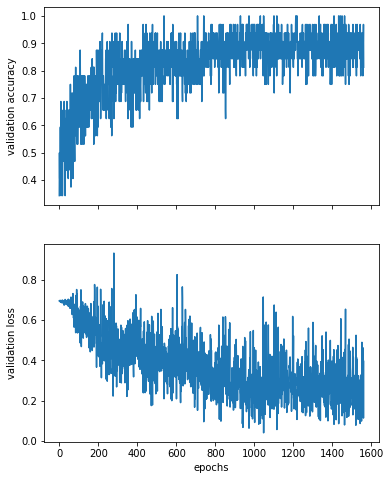

In [ ]:
def plot_history(loss_list,  accuracy_list):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 8), sharex=True)

  ax1.plot(accuracy_list)
  ax1.set_ylabel("validation accuracy")
  ax2.plot(loss_list)
  ax2.set_ylabel("validation loss")
  ax2.set_xlabel("epochs")
  plt.show()

  return

plot_history(batch_history["loss"],  batch_history["accuracy"]) 